In [755]:
import pandas as pd
import numpy as np
import matplotlib as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Flatten 
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from dropconnect_tensorflow import DropConnectConv2D, DropConnectDense
import os
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from PIL import Image
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

nella prima parte procedo con l'importing dei moduli necessari per affrontare la costruzione della rete neurale di tipo CNN (Convolution neural network):
1 Keras.models -> usata per imporatre il modello di rete neurale in questo caso trattasi di una rete di tipo sequenziale, rete che permette di riprodurre una struttura di tipo feed forward
2 keras.layers -> usata per aggiungere i layer alla rete essendo rete neurale tipo CNN la quale presenta una struttura standardizzatta mi è possibile importare i 3 livelli notoriamente utilizzati nelle reti CNN cioè Convolution, RELU, Pooling e alla fine fully connect
3

In [756]:
task_12_path = '/Users/alfredovecchio/Desktop/Progetto Machine Learning Alfredo Vecchio/TASK_12'

In tale sezione del codice procedo con la realizzazione di funzioni apposite le quali saranno richiamate nel corso del codice:


In [757]:
def get_images_from_task_folder(task_path, dim):

    def reader(main_directory, folder, dim):
        images = {"hc" : [], "pt": []}
        sub_directory = ["Test","Train","Val"]
        print("Caricamento immagini " + folder + "...")
        for i in sub_directory:
            hc_dir = os.path.join(main_directory, folder, i,"HC")
            pt_dir = os.path.join(main_directory, folder, i,"PT")
            for image in os.listdir(hc_dir):
                img = Image.open(hc_dir + '/' + image)
                if dim is not None: img = img.resize((dim, dim))
                img = img_to_array(img,dtype = np.int32)
                images["hc"].append(img)
            for image in os.listdir(pt_dir):
                img = Image.open(pt_dir + '/' + image)
                if dim is not None: img = img.resize((dim, dim))
                img = img_to_array(img,dtype = np.int32)
                images["pt"].append(img)
        return images

    all_images = reader(task_path, "Fold1", dim)
    temp = reader(task_path, "Fold2", dim)
    all_images["hc"] = np.concatenate((all_images["hc"], temp["hc"]))
    all_images["pt"] = np.concatenate((all_images["pt"], temp["pt"]))
    temp = reader(task_path, "Fold3", dim)
    all_images["hc"] = np.concatenate((all_images["hc"], temp["hc"]))
    all_images["pt"] = np.concatenate((all_images["pt"], temp["pt"]))
    temp = reader(task_path, "Fold4", dim)
    all_images["hc"] = np.concatenate((all_images["hc"], temp["hc"]))
    all_images["pt"] = np.concatenate((all_images["pt"], temp["pt"]))
    temp = reader(task_path, "Fold5", dim)
    all_images["hc"] = np.concatenate((all_images["hc"], temp["hc"]))
    all_images["pt"] = np.concatenate((all_images["pt"], temp["pt"]))
    return all_images["hc"], all_images["pt"]


In [758]:
hc, pt = get_images_from_task_folder(task_12_path,64)

Caricamento immagini Fold1...
Caricamento immagini Fold2...
Caricamento immagini Fold3...
Caricamento immagini Fold4...
Caricamento immagini Fold5...


In [759]:
print("Stampo il formato delle immagini dei primi dieci elementi delle immagini HC: ","\n",hc[:10].shape) 

Stampo il formato delle immagini dei primi dieci elementi delle immagini HC:  
 (10, 64, 64, 3)


In [760]:
print("Stampo il formato delle immagini dei primi dieci elementi delle immagini PT: ","\n",pt[:10].shape) 

Stampo il formato delle immagini dei primi dieci elementi delle immagini PT:  
 (10, 64, 64, 3)


Concateno le immagini:

In [761]:
all_images_together = np.concatenate((hc, pt))
all_images_together.shape

(839, 64, 64, 3)

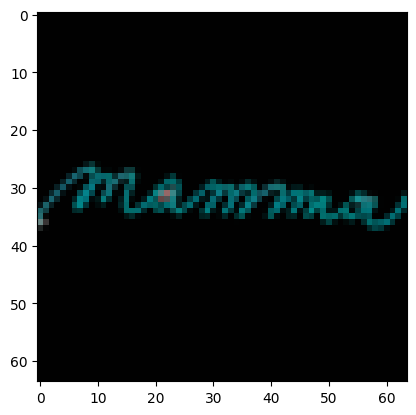

In [762]:
plt.imshow((all_images_together[0] * 255).astype(np.uint8))


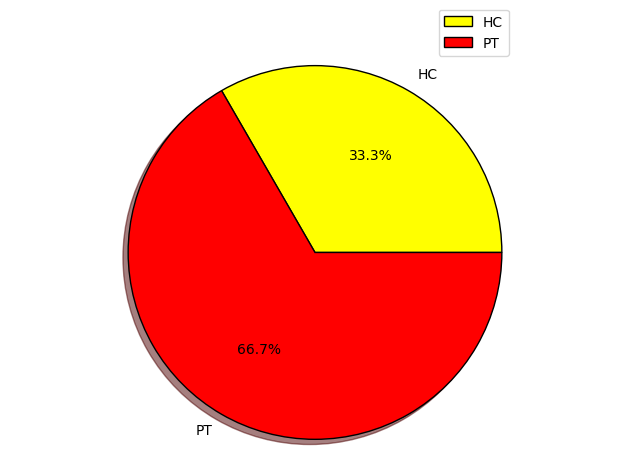

In [763]:
color = ["yellow","red"]
sizes = [15, 30]
label =['HC', 'PT']
fig1,ax1 = plt.subplots()
ax1.pie(sizes,colors=color, labels = label, wedgeprops={'edgecolor':'black'},autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
angle = np.deg2rad(67.5)
ax1.legend(loc="lower left",
          bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))
plt.tight_layout()

codifico l'etichetta creata con il label encoder, tattasi di un metod presente all'interno del modulo sklearn

In [764]:
#creo l'oggetto che userò come encoder
le = LabelEncoder()
labels_hc = ['hc']*len(hc)
labels_pt = ['pt']*len(pt)
all_images_labels_encoded = le.fit_transform(np.concatenate((labels_hc, labels_pt)))
print(all_images_labels_encoded) 


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [765]:
x_train, X_test, y_train, Y_test = train_test_split(all_images_together,all_images_labels_encoded,test_size=0.25,random_state=42)

In [766]:
x_train.shape

(629, 64, 64, 3)

In [767]:
X_test.shape

(210, 64, 64, 3)

In [768]:
y_train.shape

(629,)

In [769]:
Y_test.shape

(210,)

Pulizia delle immagini:

In [770]:
images_together_x = np.concatenate((x_train, X_test))
labels_together_y = np.concatenate((y_train, Y_test))

In [771]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.25)

train_generator = train_datagen.flow(   images_together_x, labels_together_y,
                                        batch_size = batch_size,
                                        shuffle= True,
                                        subset = "training")


validation_generator = train_datagen.flow(  images_together_x, labels_together_y,
                                            batch_size = batch_size,
                                            shuffle= False,
                                            subset = "validation")
print(len(train_generator))
print(len(images_together_x))




20
839


Creazione della rete neurale:

In [772]:
model = Sequential()
#->TODO TUNING (cambaiando parametri e fiuttandola il più possibile sui dati presenrti (customizzarlòa il più possibbile))
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation="relu", input_shape = (64,64,3), kernel_initializer='he_normal', padding = 'same'))
print(model.output_shape)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              #metrics=['accuracy']
              metrics = ["accuracy", tf.keras.metrics.AUC(name='AUC'),
                      tf.keras.metrics.Precision(name='Precision'),
                      tf.keras.metrics.Recall(name='Recall')])


#la callback è stata insertita  come prova e sarà usata nei prossimi tuning della rete in modo da bloccare la compilazione
#della rete non appena viene raggiunto un certo livello di accuracy

""" 
es_callback = EarlyStopping(monitor='accuracy', mode='min', patience=17,
                                              verbose=1, min_delta=0.03, restore_best_weights=True)
 """
             
model.summary()

(None, 64, 64, 32)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 activation_170 (Activation)  (None, 64, 64, 32)       0         
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_103 (Conv2D)         (None, 30, 30, 32)        9248      
                                                                 
 activation_171 (Activation)  (None, 30, 30, 32)       0         
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 15, 15, 32)       0         
 ng2D)                            

In [773]:
""" history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator) // batch_size,
        epochs=80,#->TODO TUNING (provvisorio per fare esecuzione veloce senza imballare)
        #callbacks= [es_callback],
        validation_data=validation_generator,
        validation_steps=len(validation_generator) // batch_size,
        verbose = 1) """

history = model.fit(train_generator,
                     steps_per_epoch = len(train_generator),
                     epochs = 100,
                     validation_data=validation_generator,
                     validation_steps=len(validation_generator) 
                     )

Epoch 1/75


2023-05-20 18:24:39.313884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - ETA: 0s - loss: 0.7216 - accuracy: 0.5238 - AUC: 0.5063 - Precision: 0.5406 - Recall: 0.6416

2023-05-20 18:24:46.769458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 9s 250ms/step - loss: 0.7216 - accuracy: 0.5238 - AUC: 0.5063 - Precision: 0.5406 - Recall: 0.6416 - val_loss: 0.7194 - val_accuracy: 0.4785 - val_AUC: 0.4946 - val_Precision: 0.4785 - val_Recall: 1.0000
Epoch 2/75
20/20 [==============================] - 5s 226ms/step - loss: 0.6930 - accuracy: 0.5238 - AUC: 0.5252 - Precision: 0.5264 - Recall: 0.9608 - val_loss: 0.6930 - val_accuracy: 0.4785 - val_AUC: 0.5800 - val_Precision: 0.4785 - val_Recall: 1.0000
Epoch 3/75
20/20 [==============================] - 4s 204ms/step - loss: 0.6928 - accuracy: 0.5175 - AUC: 0.5183 - Precision: 0.5312 - Recall: 0.7169 - val_loss: 0.6927 - val_accuracy: 0.4785 - val_AUC: 0.5669 - val_Precision: 0.4785 - val_Recall: 1.0000
Epoch 4/75
16/20 [=======================>......] - ETA: 0s - loss: 0.6900 - accuracy: 0.5299 - AUC: 0.5522 - Precision: 0.5293 - Recall: 0.9887

KeyboardInterrupt: 

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,50)), y=history.history['accuracy'],
                         line=dict(color='firebrick', width=2, dash='dash'), name='AUC'))
fig.add_trace(go.Scatter(x=list(range(1,50)), y=history.history['Recall'],
                         line=dict(color='orange', width=2), name='Recall'))
 
fig.add_trace(go.Scatter(x=list(range(1,50)), y=history.history['Precision'],
                         line=dict(color='turquoise', width=2), name='Precision'))

fig.update_layout(title_text='Plot of evaluation metrics', font_size=15, xaxis_title='Epochs')
fig.show()

Plotto gli array contenenti Loss and Accuracy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


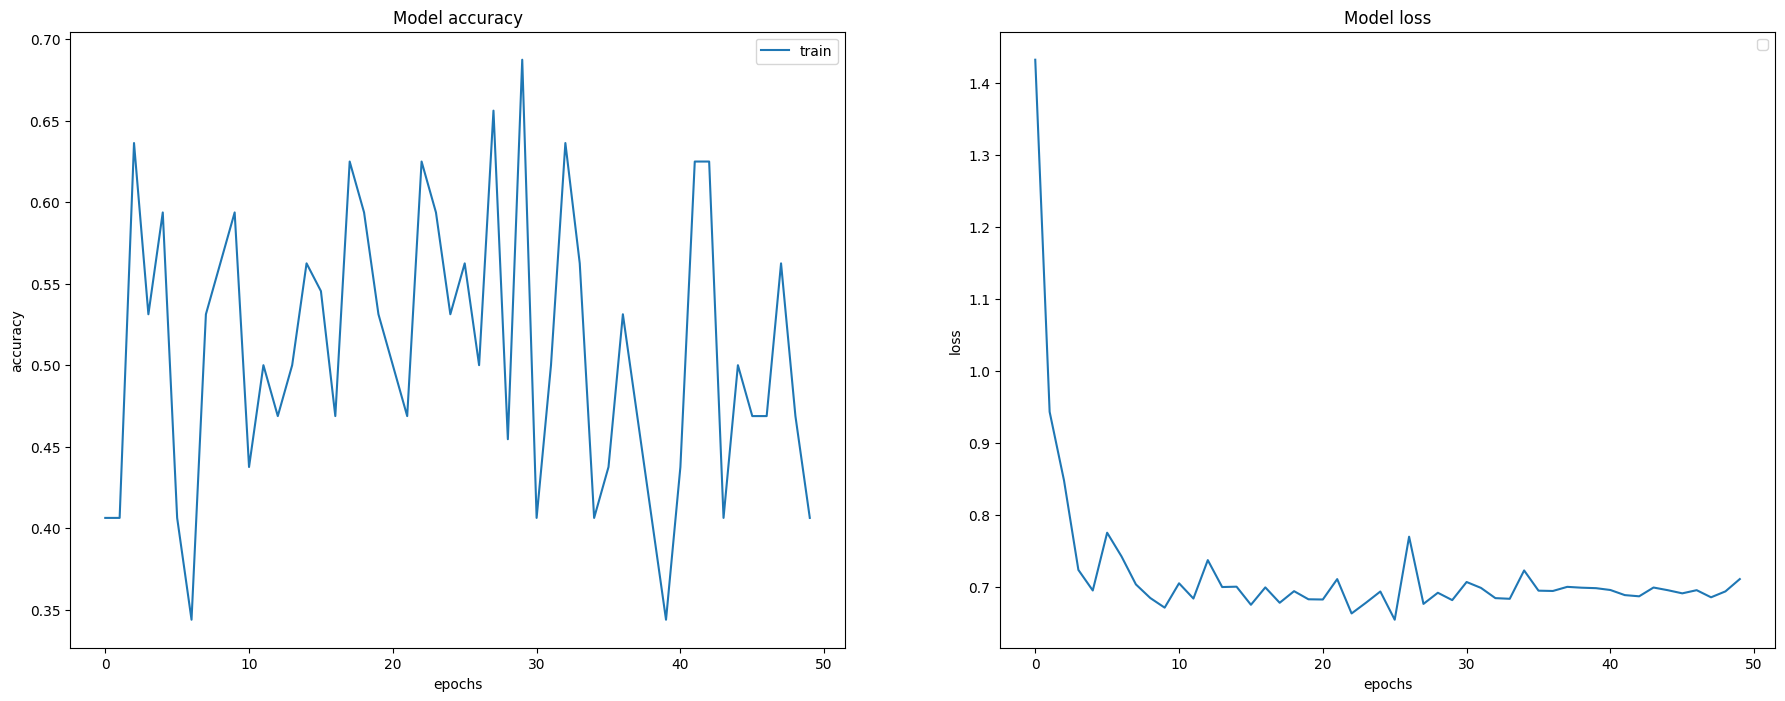

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
ax = ax.ravel()


for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    #ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
#plt.plot(history.history['val_loss'], label = 'training loss')
#plt.plot(history.history['val_accuracy'], label = 'training accuracy')
plt.legend()

In [ ]:
score =model.evaluate(X_test,Y_test, verbose =1)

6/6 [==============================] - 1s 22ms/step - loss: 4.1067 - accuracy: 0.4524 - AUC: 0.5380 - Precision: 0.0000e+00 - Recall: 0.0000e+00


In [ ]:
from sklearn.metrics import classification_report
prediction = model.predict(X_test, batch_size=16)
prediction = np.argmax(prediction, axis=1)
print(classification_report(Y_test, prediction, digits = 3))

11/11 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0      0.452     1.000     0.623        76
           1      0.000     0.000     0.000        92

    accuracy                          0.452       168
   macro avg      0.226     0.500     0.311       168
weighted avg      0.205     0.452     0.282       168



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, prediction)
print(cm)

[[76  0]
 [92  0]]


Text(0.5, 23.52222222222222, 'Predicted label')

<Figure size 1000x400 with 0 Axes>

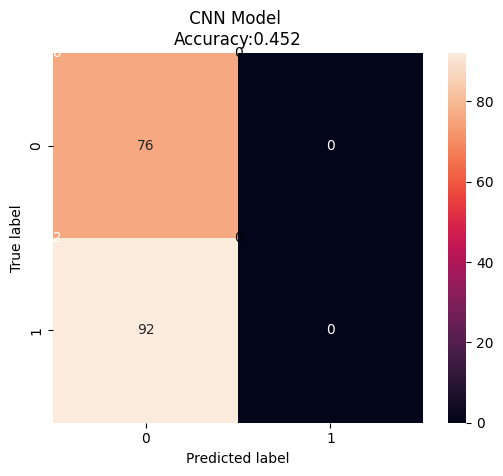

In [ ]:
from sklearn import linear_model
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import sklearn as skplt
df_cm = pd.DataFrame(cm)
plt.figure(figsize=(10,4))
sns.heatmap(df_cm, annot=True)
plt.title(' CNN Model  \nAccuracy:{0:.3f}'.format(accuracy_score(Y_test, prediction)))
plt.ylabel('True label')
plt.xlabel('Predicted label')